In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
from statsmodels.stats.anova import AnovaRM
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.signal import find_peaks, peak_prominences, peak_widths
from scipy.integrate import trapezoid
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import iqr
import math

In [2]:
def load_and_normalize_data(filepath):
    ftir_df = pd.read_csv(filepath)
    index_labels = ftir_df.index
    ftir_abs = ftir_df.filter(regex='Absorbance_')
    ftir_wavelength = ftir_df.filter(regex='Wavenumber\[1/cm\]_')

    sorted_indices = ftir_wavelength.iloc[0].argsort()[::-1]
    ftir_wavelength = ftir_wavelength.iloc[:, sorted_indices]
    ftir_abs = ftir_abs.iloc[:, sorted_indices]

    # Subtract min and divide by max-min for each row to normalize
    ftir_abs_normalized = (ftir_abs.subtract(ftir_abs.min(axis=1), axis=0)
                                .div(ftir_abs.max(axis=1) - ftir_abs.min(axis=1), axis=0))
    return ftir_wavelength, ftir_abs_normalized, index_labels

filepath = "/Users/suhasmathey/Library/CloudStorage/OneDrive-UniversityofDelaware-o365/Spring_24/ELEG848 Soft Materials Inn/FTIR Data/FTIR_data.csv"
ftir_wavelength, normalized_absorbance, index_labels = load_and_normalize_data(filepath)

print(ftir_wavelength)
print(normalized_absorbance)
print(index_labels)

    Wavenumber[1/cm]_1  Wavenumber[1/cm]_2  Wavenumber[1/cm]_3  \
0             3999.706            3997.778            3995.849   
1             3999.706            3997.778            3995.849   
2             3999.706            3997.778            3995.849   
3             3999.706            3997.778            3995.849   
4             3999.706            3997.778            3995.849   
5             3999.706            3997.778            3995.849   
6             3999.706            3997.778            3995.849   
7             3999.706            3997.778            3995.849   
8             3999.706            3997.778            3995.849   
9             3999.706            3997.778            3995.849   
10            3999.706            3997.778            3995.849   
11            3999.706            3997.778            3995.849   

    Wavenumber[1/cm]_4  Wavenumber[1/cm]_5  Wavenumber[1/cm]_6  \
0             3993.921            3991.992            3990.064   
1        

In [3]:
def perform_anova(wavelength, absorbance, bin_size):

    total_points = absorbance.shape[1]
    num_bins = total_points // bin_size
    remaining_points = total_points % bin_size
    anova_results = pd.DataFrame()
    anova_data = []

    for bin_index in range(num_bins + int(remaining_points > 0)):
        start = bin_index * bin_size
        if bin_index < num_bins:
            end = start + bin_size
        else:
            end = start + remaining_points
        
        current_bin_absorbance = absorbance.iloc[:, start:end].values.flatten()
        current_bin_size = end - start
        current_bin_wavelength = np.tile(wavelength.iloc[:, start:end].values.flatten(), absorbance.shape[0])[:len(current_bin_absorbance)]
        current_bin_materials = np.repeat(absorbance.index, current_bin_size)[:len(current_bin_absorbance)]

        anova_data = pd.DataFrame({
            'Absorbance': current_bin_absorbance,
            'Wavelength': current_bin_wavelength,
            'Material': current_bin_materials
        })

        print(anova_data)



        anova = AnovaRM(data=anova_data, depvar='Absorbance', subject='Material', within=['Wavelength']).fit()

        anova_results = anova_results.append({
            'Bin': bin_index + 1,
            'F-Value': anova.anova_table['F Value'][0],
            'P-Value': anova.anova_table['Pr > F'][0],
            'DF Within': anova.anova_table['Num DF'][0],
            'DF Between': anova.anova_table['Den DF'][0]
        }, ignore_index=True)
    
        anova_data.append(anova_data)

    return anova_results, anova_data



bin_size = 300

anova_results, anova_data = perform_anova(ftir_wavelength, normalized_absorbance, bin_size)


#print(anova_data)
print(anova_results)


      Absorbance  Wavelength  Material
0       0.011839    3999.706         0
1       0.011779    3997.778         0
2       0.011751    3995.849         0
3       0.011721    3993.921         0
4       0.011694    3991.992         0
...          ...         ...       ...
3595    0.182334    3430.799        11
3596    0.183652    3428.870        11
3597    0.184895    3426.942        11
3598    0.186093    3425.013        11
3599    0.187380    3423.085        11

[3600 rows x 3 columns]
      Absorbance  Wavelength  Material
0       0.262815    3421.156         0
1       0.264423    3419.228         0
2       0.266119    3417.299         0
3       0.267807    3415.371         0
4       0.269380    3413.442         0
...          ...         ...       ...
3595    0.135536    2852.249        11
3596    0.130167    2850.321        11
3597    0.125133    2848.392        11
3598    0.120253    2846.464        11
3599    0.115783    2844.535        11

[3600 rows x 3 columns]
      Absorban

In [4]:
def extract_data_from_significant_bins(data, significant_bins, bin_size):
    # Initialize a list to hold the DataFrame for each sample
    extracted_data = []

    # Iterate over each sample in the dataset
    for sample_index in range(data.shape[0]):
        sample_data = []

        # Iterate over each significant bin to extract data
        for _, bin_row in significant_bins.iterrows():
            start_index = int((bin_row['Bin'] - 1) * bin_size)
            end_index = min(start_index + bin_size, data.shape[1])

            # Extract the intensities for the current bin and sample
            current_bin_data = data.iloc[sample_index, start_index:end_index]

            
            sample_data.extend(current_bin_data.values)

        # Append the sample data to the list
        extracted_data.append(sample_data)

    # Convert the list of lists to a DataFrame
    num_columns = len(extracted_data[0])  # Number of columns for the DataFrame
    return pd.DataFrame(extracted_data, columns=[f'Intensity_{i}' for i in range(num_columns)])


bin_size = 300
significant_bins = anova_results[anova_results['P-Value'] < 0.05]

print(significant_bins)

extracted_data = extract_data_from_significant_bins(normalized_absorbance, significant_bins, bin_size)
#print(extracted_data)


   Bin  DF Between  DF Within      F-Value  P-Value
0  1.0      3289.0      299.0   780.830991      0.0
1  2.0      3289.0      299.0   437.389590      0.0
2  3.0      3289.0      299.0  2723.766340      0.0
3  4.0      3289.0      299.0   124.713109      0.0
4  5.0      3289.0      299.0  2594.227752      0.0
5  6.0      3289.0      299.0  1543.880648      0.0
6  7.0       737.0       67.0   977.280095      0.0


In [5]:

def extract_and_bin_data(data, ppm_values, significant_bins, bin_size):
    binned_areas = []

    # Iterate over each sample in the dataset
    for sample_index in range(data.shape[0]):
        sample_areas = []

        # Iterate over each significant bin to extract data and compute the area under the curve
        for _, bin_row in significant_bins.iterrows():
            start_index = int((bin_row['Bin'] - 1) * bin_size)
            end_index = min(start_index + bin_size, data.shape[1])

            # Extract the intensities and corresponding PPM values for the current bin and sample
            current_bin_data = data.iloc[sample_index, start_index:end_index]
            current_bin_ppm = ppm_values.iloc[:, start_index:end_index]

            # Calculate the area under the curve using np.trapz
            area = np.trapz(current_bin_data, current_bin_ppm.iloc[0])
            sample_areas.append(area)

        # Append the binned areas for the current sample
        binned_areas.append(sample_areas)

    # Convert the list of lists to a DataFrame
    num_columns = len(binned_areas[0])  # Number of columns for the DataFrame
    return pd.DataFrame(binned_areas, columns=[f'Area_Bin_{i+1}' for i in range(num_columns)])

binned_data = extract_and_bin_data(normalized_absorbance, ftir_wavelength, significant_bins, bin_size)

print(binned_data)

    Area_Bin_1  Area_Bin_2  Area_Bin_3  Area_Bin_4  Area_Bin_5  Area_Bin_6  \
0   -32.887731 -103.111470  -15.768835   -9.000011  -81.847171 -245.258228   
1   -32.745762  -93.031888  -29.505218  -16.479274  -89.638204 -251.795313   
2   -28.436505  -90.622911  -17.247261   -9.211553  -78.476469 -241.191777   
3   -27.650960  -94.313750  -15.117276   -7.799747  -78.148795 -242.382029   
4   -33.739508  -98.100448  -22.636517  -12.961735  -85.021104 -250.293731   
5   -35.710768 -102.813583  -22.237388  -13.083702  -86.595834 -252.705394   
6   -31.075082  -95.954705  -20.943906  -10.916709  -85.361228 -251.134976   
7   -33.762870  -95.783782  -22.177886  -12.447643  -85.834005 -242.203697   
8   -34.199403 -100.538013  -20.234085  -11.535473  -87.077968 -246.105295   
9   -33.311205 -101.084183  -18.661420  -10.914696  -85.938171 -244.686104   
10  -34.471518  -92.720590  -27.018746  -15.244459  -88.311287 -246.651093   
11  -25.070758  -88.892629  -22.963375  -12.457916  -85.014652 -

          PC1        PC2       PC3
0   -9.787208   5.268063 -0.176867
1   13.382795  -0.268252 -0.534441
2   -6.182034  -9.970519  0.684156
3   -9.580998  -6.861551 -1.193271
4    1.757151   3.823061 -1.747273
5    1.041596  10.070775 -2.542367
6    0.661685   1.405090 -4.283327
7    0.573571  -1.334698  5.286850
8   -1.695517   4.979500  1.966651
9   -4.217215   4.224996  2.211522
10   9.065141  -1.682792  3.614877
11   4.981034  -9.653673 -3.286510
[0.49556577 0.39902432 0.08357973]


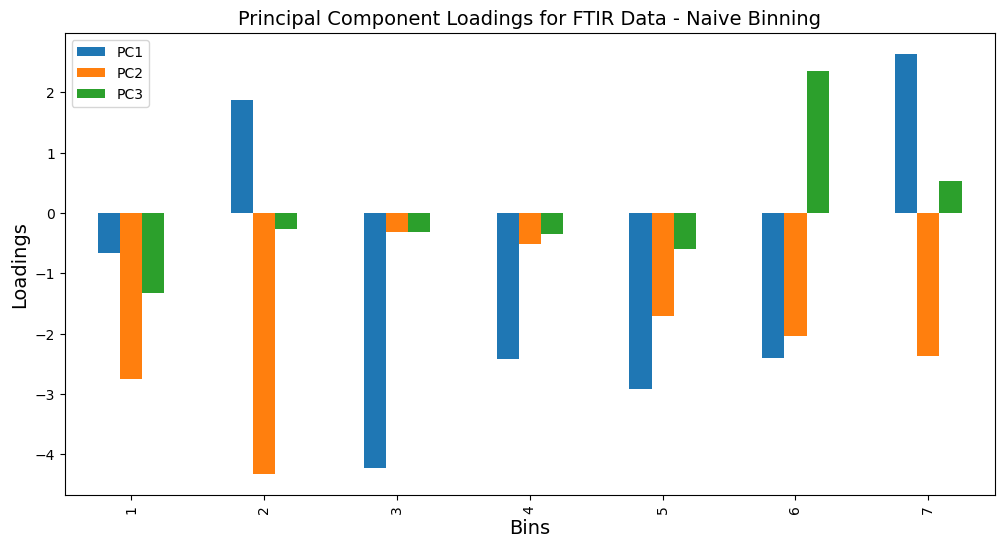

In [6]:
pca = PCA(n_components=3)
binned_data.columns = [col.replace('Bin', 'Peak') for col in binned_data.columns]

binned_data.columns = [str(i+1) for i in range(len(binned_data.columns))]


principal_components = pca.fit_transform(binned_data)

principal_components_df = pd.DataFrame(principal_components,index=index_labels, columns=['PC1', 'PC2', 'PC3'])
print(principal_components_df)
print(pca.explained_variance_ratio_)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'], index=binned_data.columns)

fig, ax = plt.subplots(figsize=(12,6))
loading_matrix.plot(kind='bar', ax=ax)
plt.title('Principal Component Loadings for FTIR Data - Naive Binning', fontsize=14)
plt.ylabel('Loadings', fontsize=14)
plt.xlabel('Bins', fontsize=14)
plt.show()

In [7]:
#principal_components_df.to_csv("/Users/suhasmathey/Library/CloudStorage/OneDrive-UniversityofDelaware-o365/Spring_24/ELEG848 Soft Materials Inn/FTIR Data/PC_naive_FTIR.csv")

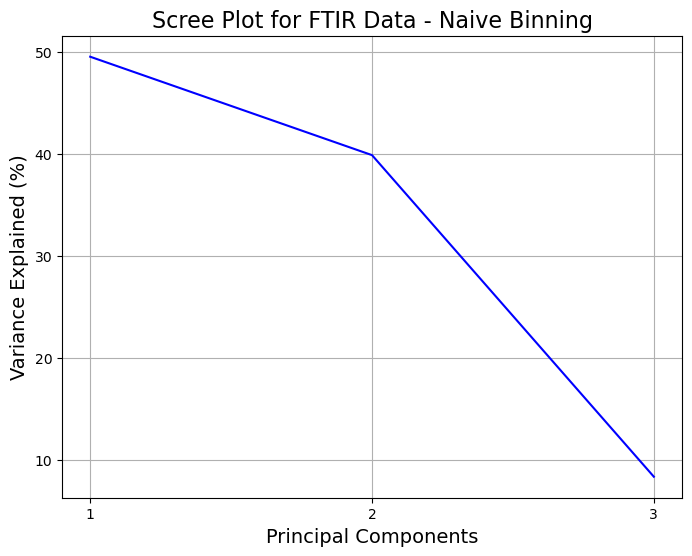

In [8]:
explained_variance = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1, len(explained_variance)+1), explained_variance*100, color='blue')
plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('Variance Explained (%)', fontsize=14)
plt.title('Scree Plot for FTIR Data - Naive Binning', fontsize=16)
plt.xticks(range(1, len(explained_variance)+1)) 
plt.grid(True)
plt.show()

In [9]:
performance_data = pd.read_csv("/Users/suhasmathey/Library/CloudStorage/OneDrive-UniversityofDelaware-o365/Spring_24/ELEG848 Soft Materials Inn/NMR_Data/tidy_performance_2.0.csv", index_col='Sample')
Y = performance_data['Performance (mean)']
X  = principal_components

Y.reset_index(drop=True, inplace=True)


poly = PolynomialFeatures(degree=1)
X_LP = poly.fit_transform(X)

C = sm.add_constant(X_LP)
ols_model = sm.OLS(Y, C).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:     Performance (mean)   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                 -0.275
Method:                 Least Squares   F-statistic:                    0.2083
Date:                Tue, 14 May 2024   Prob (F-statistic):              0.888
Time:                        11:16:59   Log-Likelihood:                -30.180
No. Observations:                  12   AIC:                             68.36
Df Residuals:                       8   BIC:                             70.30
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.1333      1.058     15.249      0.0

/Users/suhasmathey/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  k, _ = kurtosistest(a, axis)


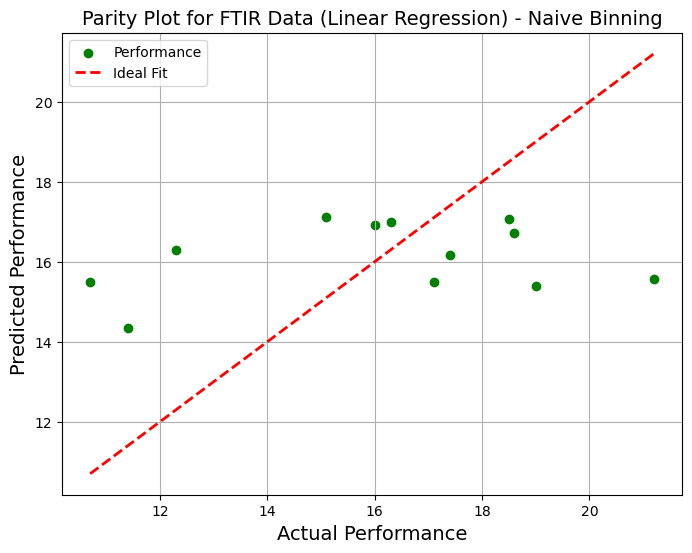

In [10]:
lin_reg = LinearRegression()
lin_reg.fit(X_LP, Y)

Y_pred = lin_reg.predict(X_LP)

plt.figure(figsize=(8, 6))
plt.scatter(Y, Y_pred, color= 'Green', label='Performance')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'r--', lw=2, label='Ideal Fit')

plt.xlabel('Actual Performance', fontsize=14)
plt.ylabel('Predicted Performance', fontsize=14)
plt.title('Parity Plot for FTIR Data (Linear Regression) - Naive Binning', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [11]:
Y_pred

array([16.98447516, 15.56924343, 15.39701008, 15.50389199, 16.17008809,
       16.71676211, 15.49472281, 16.91842381, 17.07136517, 17.11770964,
       16.30303403, 14.35327368])